## Group 1
### (Models - Logistic Regression, Random Forest Classifier, Decision Tree Classifier)

In [49]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
from typing import Tuple
import copy as cp
from pandas import DataFrame
from matplotlib import pyplot as plt 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score,roc_auc_score,\
accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_validate,StratifiedKFold,KFold,cross_val_predict
from sklearn import tree
import seaborn as sns


from numpy import array
import warnings
warnings.filterwarnings('ignore')

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suvijain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/suvijain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Loading datasets for Eclipse, Mozilla, Thunderbird and combining to form 3 different dataframes

In [50]:
# Loading all the given datasets in 6 dataframes

df1 = pd.read_csv('EP_nondup.csv',sep=';')
df2 = pd.read_csv('EP_dup.csv',sep=';')
df3 = pd.read_csv('M_Duplicate BRs.csv',sep=';')
df4 = pd.read_csv('M_NonDuplicate BRs.csv',sep=';')
df5 = pd.read_csv('dup_TB.csv',sep=';')
df6 = pd.read_csv('Nondup_TB.csv',sep=';')

frames_ecl = [df1,df2]
frames_moz = [df3,df4]
frames_tb = [df5,df6]

# Concatenating 2 datasets for each of the platforms to form 3 datasets
df_ecl = pd.concat(frames_ecl)
df_moz = pd.concat(frames_moz)
df_tb = pd.concat(frames_tb)
df = pd.concat([df_ecl,df_moz,df_tb])

In [51]:
print(len(df_ecl)+len(df_moz)+len(df_tb))

122075


In [52]:
df_ecl.head()

,Issue_id,Duplicated_issue,Title1,Description1,Title2,Description2,Label
0,1,92840,usability issue with external editors geirl,setup a project that contains a .gif resource \t release project to cvs \t edit the .gif resource with an external editor e.g. paintshop \t save and close external editor \t in navigator open the icon resource and verify that your changes are there \t release project \t\t nothing to release \t in navigator open the icon resource and verify that your changes are still there \tproblem because i never refreshed from local the workspace hasnt changed so release didnt find anything. \thowever opening the resource with an external editor found the modified file on disk and showed the changes. \tthe real problem occurs if release actually finds something to release but you dont spot that some resources are missing. \tthis is extremely error prone one of my changes didnt made it into because of this egpm \trelease should do a refresh from local before doing the release. \tmoving to vcm kmpm \tcomments from jm in related email \tshould not do this for free. could have a setting which made it optoinal but should nt be mandatory. default setting could be to have it on. \tconsider the swt team who keep their workspaces on network drives. this will be slow. \tside effects will be that a runs when the refresh is completed unless you somehow do it in a workspace runnable and dont end the \trunnable until after the release. this would be less than optimal as some ers may be responsible for maintaining some invariants and deriving resources which are releasable. if you dont run the ers before releasing the invariants will not be maintained and you will release inconsistent state. \tsummary offer to ensure local consistency before releasing. kmpm \tsee also geaga itpvcmwinnt internal error comparing with a document \twhich failed with an error. never got log from tod though.closedfixed.,api deleted field idebuguiconstants.imgactsynced,. head idebuguiconstants public static final string imgactsynced this field was deleted sometime in . cycle. this would be a breaking api change. whats the story,0
1,2,92844,opening repository resources doesnt honor type geiq,opening repository resource open the default text editor and doesnt \thonor any mapping between resource types and editors. \tas a result it is not possible to view the contents of an image .gif file in a sensible way. egam \tagreed that this is needed eventually but not critical for june. \t \tthere should also be a java outliner when editing a java resource from the repository. \tmoving to vcm. kmpm \tin general you cannot open a specialized editor on a remote resource because they can \tbe dependent on other resources and expect these to be local. for example an html page which \treferences a graphic the html editor is going to try to look for the graphic to display it. \tyou cant be sure that the editor was written to accomodate remote or missing resources. \twe discussed this some time ago with dave t. and felt it was safer to just use vanilla editors for now. kmpm \tsee also geymj itpvcmall repositories view all file types open to the text editorresolvedfixed.,increase scrolling speed based on distance from the widget,currently the speed of selection scrolling when using the mouse in styledtext is fixed. this means it can take a long time to select large sections of text. it would be much better if styledtext increased the selection speed based on the distance the pointer is from the edge of the styledtext widget.,0
2,3,92850,sync does not indicate deletion gien,kmpm \tthis pr about the deletion indicator in the sync viewer being too subtle. \tthis would be even more true for someone with vision problems. \tne has good suggestion of using the label of the compare text viewer. \twe may also consider a better icon. \ton to the pr.... delete file from project synchronize there is no indication that the file has been deleted from the workspace it looks the same as i

In [5]:
print("Eclipse dataset shape: ",df_ecl.shape)
print("Mozilla dataset shape: ",df_moz.shape)
print("Thunderbird dataset shape: ",df_tb.shape)
print("Complete dataset shape: ",df.shape)

Eclipse dataset shape:  (46908, 7)
Mozilla dataset shape:  (60904, 7)
Thunderbird dataset shape:  (14263, 7)
Complete dataset shape:  (122075, 7)


In [53]:
# Counting the unique values in label for the 3 datasets
print(df_ecl['Label'].value_counts())
print(df_moz['Label'].value_counts())
print(df_tb['Label'].value_counts())
print(df['Label'].value_counts())

print(df_ecl['Label'].value_counts(normalize=True) * 100)
print(df_moz['Label'].value_counts(normalize=True) * 100)
print(df_tb['Label'].value_counts(normalize=True) * 100)
print(df['Label'].value_counts(normalize=True) * 100)

0    34222
1    12686
Name: Label, dtype: int64
0    36833
1    24071
Name: Label, dtype: int64
0    9905
1    4358
Name: Label, dtype: int64
0    80960
1    41115
Name: Label, dtype: int64
0    72.955573
1    27.044427
Name: Label, dtype: float64
0    60.477144
1    39.522856
Name: Label, dtype: float64
0    69.445418
1    30.554582
Name: Label, dtype: float64
0    66.319885
1    33.680115
Name: Label, dtype: float64


#### Data shuffle 

In [54]:
df_ecl = df_ecl.sample(frac=1).reset_index(drop=True)
df_moz = df_moz.sample(frac=1).reset_index(drop=True)
df_tb = df_tb.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

In [55]:
df_ecl = df_ecl.drop(columns=['Issue_id','Duplicated_issue'])
df_moz = df_moz.drop(columns=['Issue_id','Duplicated_issue'])
df_tb = df_tb.drop(columns=['Issue_id','Duplicated_issue'])
df = df.drop(columns=['Issue_id','Duplicated_issue'])

In [56]:
df_moz

,Title1,Description1,Title2,Description2,Label
0,child windows opening on wrong monitor example drop down menus,note im running two monitors at two different resolutions with an ati mobility radeon card. when i click on any of the drop down menus the menu is actually displayed on the other monitor a similar thing happens when entering a url the drop down select box for different urls shows up on the other monitor. all of the contents in the menus still work though. screen shots httpwww.msu.eduhatchseafirefoxfirefox.jpg httpwww.msu.eduhatchseafirefoxfirefox.jpg it happens every time right now but i havent completely closed every instance of firefox because im doing this. i will complete this in a little bit,right click menu in second screen appears on main monitor in a dual monitor setup,on a a dual setup monitor ati radeon when the second screen is on top of the main screen when the right click menu appear at the top edge of the main screen. i did not notice this behaviour before when the second screen was to teh left of the main screen. right now i have changed settings and moved the screen to the left and i get same behaviour only this time the right click menu appears at the left edge of the main screen. i havent restarted my browser yet... its a possible regression or somethings.... since . i never had this bug but i never moved my second screen on top. . move second screen to be on top of the main screen . right click on a page menu opens on top edge of main screen possible caused by screen being on top of main screen,1
1,tools facebook messenger remove from nightly doesnt do anything,i have a facebook button in my toolbar though its just the f logo button. i wanted to remove it so i went to tools facebook messenger remove from nightly. i was prompted as to whether i wanted it removed answered in the affirmative but doing so had no effect. no errors in the error log either. might this have something to do with it being deactivated turn on facebook messenger is the only other menu item in facebook messenger.,tools facebook messenger menu shown when social api is disabled,i updated my nightly just now and i got a tools facebook messenger menu with a single item in it remove from nightly. i havent enabled the social api so i think the menu shouldnt be shown at all.,1
2,firefox cursor disappears after loading java applet,load any java applet makes the cursor disappears in firefox . many users are reporting the same issue as well goto httpforums.mozillazine.orgviewtopic.phpft example goto httpmainline.brynmawr.educoursescsspringappletssmileysmiley.html which has a simple applet use the applet try to goto a different website the cursor is gone. the only way to get the cursor back is to toggle the window away from firefox to a different application and back. this is happening in windows cursor shouldnt disappear,after java app launch can not click in any form or the location bar,after todays .. update to aurora and installing java update i restarted firefox and when i try to use the shell java app for my smoothwall linux router nothing really happens in the shell. should be a java to ssh connect but what ever. note this is the only windows system i have and have not tried it on any of my linux systems yet. i am unable to click in the url location bar to type select text etc. i can not click in any form boxes to type like the email password boxes to enter bugzilla.. i have to quit and restart to be able to type anywhere. this persists even when smoothwall ssh shell java app tab is closed. note this is the only windows system i have and have not tried it on any of my linux systems yet. either the java app should fail or i should be able to type at least in the location bar,1
3,after clozing mozilla when opening again mozilla does not open.,i close mozilla firefox and then when i need to open it again it does not open. can be resolved by going into task manager ctrlaltdel and going into processes then ending all firefox.exe process

### Combining the text in Title and description column for all datasets in order to vectorize them together

In [59]:
df_ecl['Bug1'] = df_ecl['Title1'].str.cat(df_ecl['Description1'],sep=" ")
df_ecl['Bug2'] = df_ecl['Title2'].str.cat(df_ecl['Description2'],sep=" ")

df_moz['Bug1'] = df_moz['Title1'].str.cat(df_moz['Description1'],sep=" ")
df_moz['Bug2'] = df_moz['Title2'].str.cat(df_moz['Description2'],sep=" ")

df_tb['Bug1'] = df_tb['Title1'].str.cat(df_tb['Description1'],sep=" ")
df_tb['Bug2'] = df_tb['Title2'].str.cat(df_tb['Description2'],sep=" ")
df_ecl.Bug1

df['Bug1'] = df['Title1'].str.cat(df['Description1'],sep=" ")
df['Bug2'] = df['Title2'].str.cat(df['Description2'],sep=" ")

### Remove puncctuations and stop words from the datasets to process

In [60]:
stop_words = set(stopwords.words('english'))

def words(text):
    text = ''.join([i for i in text if i not in punctuation])
    text = text.lower()
    text = text.split()
    text = [j for j in text if not j in stop_words]
    text = " ".join(text)
    return(text)

In [61]:
def preprocess(bug_reports,bugs_all):
    for n in bugs_all:
        bug_reports.append(words(n))

In [62]:
bug_pp_ecl1 = []
bug_pp_ecl2 = []

bug_pp_moz1 = []
bug_pp_moz2 = []

bug_pp_tb1 = []
bug_pp_tb2 = []

bug_pp_all1 = []
bug_pp_all2 = []

preprocess(bug_pp_ecl1, df_ecl.Bug1)
preprocess(bug_pp_ecl2, df_ecl.Bug2)

preprocess(bug_pp_moz1, df_moz.Bug1)
preprocess(bug_pp_moz2, df_moz.Bug2)

preprocess(bug_pp_tb1, df_tb.Bug1)
preprocess(bug_pp_tb2, df_tb.Bug2)

preprocess(bug_pp_all1, df.Bug1)
preprocess(bug_pp_all2, df.Bug2)

### Define TFIDF veectorizer

In [63]:
tfidf_ecl = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 900,norm = 'l2')
tfidf_moz = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 900,norm = 'l2')
tfidf_tb = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 900,norm = 'l2')
tfidf_all = TfidfVectorizer(analyzer = 'word',stop_words = 'english',lowercase = True,max_features = 900,norm = 'l2')

In [64]:
words_ecl = pd.concat([df_ecl.Bug1,df_ecl.Bug2], axis = 0)
words_moz = pd.concat([df_moz.Bug1,df_moz.Bug2], axis = 0)
words_tb = pd.concat([df_tb.Bug1,df_tb.Bug2], axis = 0)
words_all = pd.concat([df.Bug1,df.Bug2], axis = 0)

In [65]:
tfidf_ecl.fit(words_ecl)
tfidf_moz.fit(words_moz)
tfidf_tb.fit(words_tb)
tfidf_all.fit(words_all)

duplicate_ecl_1 = tfidf_ecl.transform(df_ecl.Bug1)
duplicate_ecl_2 = tfidf_ecl.transform(df_ecl.Bug2)

duplicate_moz_1 = tfidf_moz.transform(df_moz.Bug1)
duplicate_moz_2 = tfidf_moz.transform(df_moz.Bug2)

duplicate_tb_1 = tfidf_tb.transform(df_tb.Bug1)
duplicate_tb_2 = tfidf_tb.transform(df_tb.Bug2)

duplicate_all_1 = tfidf_all.transform(df.Bug1)
duplicate_all_2 = tfidf_all.transform(df.Bug2)

In [68]:
x_ecl = abs(duplicate_ecl_1 - duplicate_ecl_2)
y_ecl = df_ecl['Label']

x_moz = abs(duplicate_moz_1 - duplicate_moz_2)
y_moz = df_moz['Label']

x_tb = abs(duplicate_tb_1 - duplicate_tb_2)
y_tb = df_tb['Label']

x_all = abs(duplicate_all_1 - duplicate_all_2)
y_all = df['Label']

In [69]:
def model_eval(x,y,classifier,cv):
    scoring = ['accuracy','precision','recall','roc_auc']
    results = cross_validate(classifier,x,y,return_estimator=True,scoring=scoring,cv=cv)
    y_pred = cross_val_predict(classifier,x,y,cv=cv)
    return (results['test_accuracy'].mean(),
           results['test_precision'].mean(),
           results['test_recall'].mean(),
           results['test_roc_auc'].mean(),y_pred)

## Cross validation for Logistic Regression, Decision Tree Classifier, & Random Forest Classifier

In [70]:
lr = LogisticRegression()
dt = tree.DecisionTreeClassifier()
rf = RandomForestClassifier()

### Logistic Regression

In [72]:
lr_acc_all,lr_prec_all,lr_rec_all,lr_auc_all,lr_pred = model_eval(x_all,y_all,lr,10)
print(confusion_matrix(y_all, lr_pred))
tn, fp, fn, tp = confusion_matrix(y_all, lr_pred).ravel()
print("True Positives:  ",tp)
print("False Positives: ",fp)
print("True Negatives:  ",tn)
print("False Negatives: ",fn)
print(classification_report(y_all, lr_pred))

[[72508  8452]
 [15685 25430]]
True Positives:   25430
False Positives:  8452
True Negatives:   72508
False Negatives:  15685
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     80960
           1       0.75      0.62      0.68     41115

    accuracy                           0.80    122075
   macro avg       0.79      0.76      0.77    122075
weighted avg       0.80      0.80      0.80    122075



### Decision Tree Classifier

In [73]:
dt_acc_all,dt_prec_all,dt_rec_all,dt_auc_all,dt_pred = model_eval(x_all,y_all,dt,5)
print(confusion_matrix(y_all, dt_pred))
tn, fp, fn, tp = confusion_matrix(y_all, dt_pred).ravel()
print("True Positives:  ",tp)
print("False Positives: ",fp)
print("True Negatives:  ",tn)
print("False Negatives: ",fn)
print(classification_report(y_all, dt_pred))

[[60180 20780]
 [18907 22208]]
True Positives:   22208
False Positives:  20780
True Negatives:   60180
False Negatives:  18907
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     80960
           1       0.52      0.54      0.53     41115

    accuracy                           0.67    122075
   macro avg       0.64      0.64      0.64    122075
weighted avg       0.68      0.67      0.68    122075



### Random Forest Classifier

In [79]:
rf_acc_all,rf_prec_all,rf_rec_all,rf_auc_all,rf_pred = model_eval(x_all,y_all,rf,2)
print(confusion_matrix(y_all, rf_pred))
tn, fp, fn, tp = confusion_matrix(y_all, rf_pred).ravel()
print("True Positives:  ",tp)
print("False Positives: ",fp)
print("True Negatives:  ",tn)
print("False Negatives: ",fn)
print(classification_report(y_all, rf_pred))

[[79095  1865]
 [23854 17261]]
True Positives:   17261
False Positives:  1865
True Negatives:   79095
False Negatives:  23854
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     80960
           1       0.90      0.42      0.57     41115

    accuracy                           0.79    122075
   macro avg       0.84      0.70      0.72    122075
weighted avg       0.81      0.79      0.76    122075



In [103]:
df_results = pd.DataFrame({'Classifier':['LR','DT','RF'],
                          'AUC':[lr_auc_all,dt_auc_all,rf_auc_all],
                          'Accuracy':[lr_acc_all,dt_acc_all,rf_acc_all],
                          'Recall':[lr_rec_all,dt_rec_all,rf_rec_all],
                          'Precision':[lr_prec_all,dt_prec_all,rf_prec_all]})
df_results.style.hide_index()

Classifier,AUC,Accuracy,Recall,Precision
LR,0.853130,0.802277,0.618509,0.750603
DT,0.642594,0.676002,0.540241,0.518263
RF,0.829217,0.788220,0.416004,0.902799


MODEL PERFORMANCE METRICS


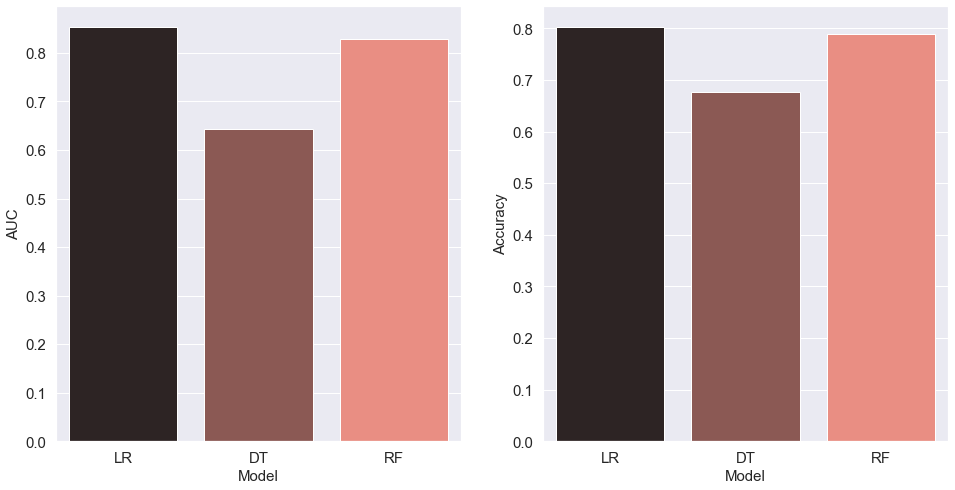

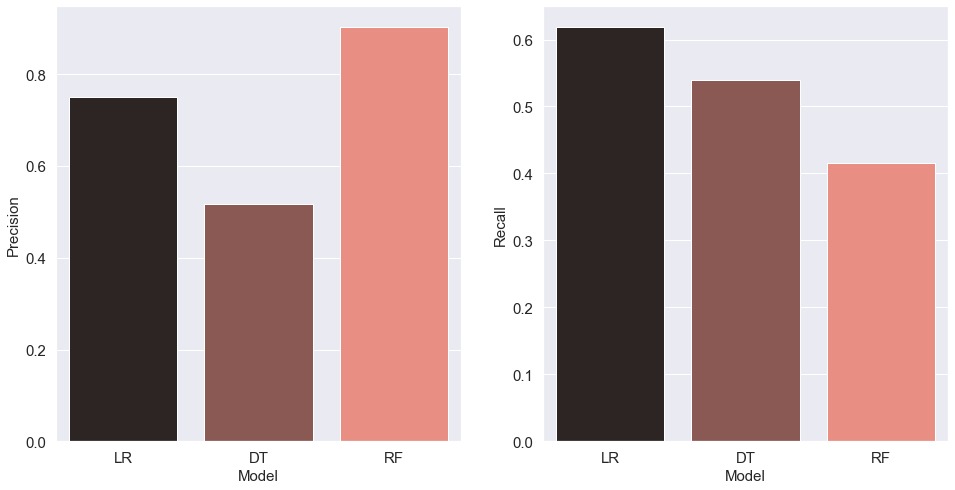

In [102]:
print("MODEL PERFORMANCE METRICS")

sns.set(style="darkgrid")

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="AUC",data=df_results,ax=axs[0],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="Accuracy",data=df_results,ax=axs[1],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="Precision",data=df_results,ax=axs[0],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Precision', fontsize = 15)
ax.tick_params(labelsize=15)

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Classifier", y="Recall",data=df_results,ax=axs[1],palette="dark:salmon")
ax.set_xlabel('Model',fontsize = 15)
ax.set_ylabel('Recall', fontsize = 15)
ax.tick_params(labelsize=15)
plt.show()